In [136]:
import numpy as np
from skimage import io, img_as_float, filters, color
from skimage.color import rgb2gray
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [137]:
image = io.imread("/Users/piotr/Downloads/MHcHVmX.jpg")
image_rgb = io.imread("/Users/piotr/Downloads/fkdjn.jpg")

In [138]:
gray_image = img_as_float(image)
gray_image.dtype, image.dtype

(dtype('float64'), dtype('uint8'))

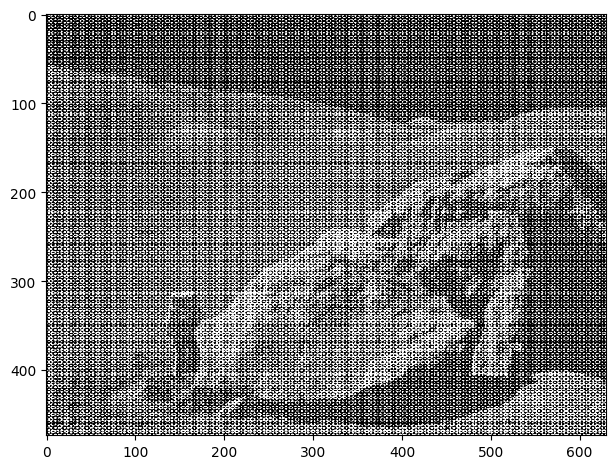

In [139]:
io.imshow(image)

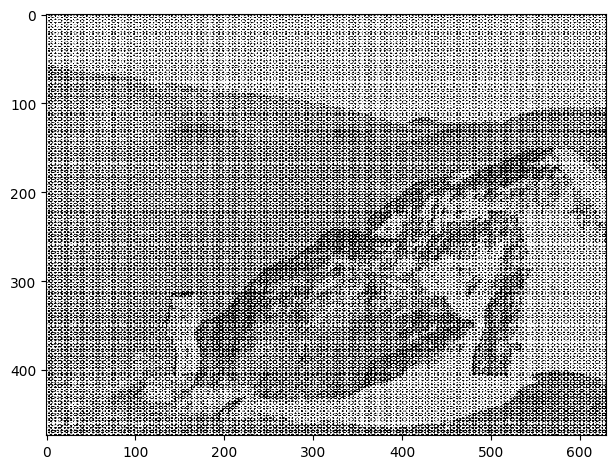

In [140]:
io.imshow(gray_image, cmap='Greys')

# **Odszumianie**

In [141]:
def denoise(image, percentile):
    # Przeprowadzenie transformaty Fouriera i przesunięcie do środka niskich częstotliwości
    f_transform = np.fft.fft2(image)
    f_magnitude = np.abs(f_transform)
    f_shifted = np.fft.fftshift(f_magnitude)

    rows, cols = image.shape
    
    # Usunięcie czestotliwości ze środka
    K = 30
    f_shifted[rows // 2 - K: rows // 2 + K, cols // 2 - K: cols // 2 + K] = 0
    
    # Znalezienie wszystkich amplitud mniejszych niż podany percentyl
    peaks = f_shifted < np.percentile(f_shifted, percentile)
    
    # Przesunięcie spowrotem
    peaks = np.fft.ifftshift(peaks)
    
    # Ustawienie amplitud poniżej percentyla na 0
    filter_peaks = f_transform * peaks.astype(int)
    
    # Odwrucenie transformaty
    filtered_image = np.fft.ifft2(filter_peaks).real
    
    filtered_image = np.clip(filtered_image, 0, 1)

    return filtered_image


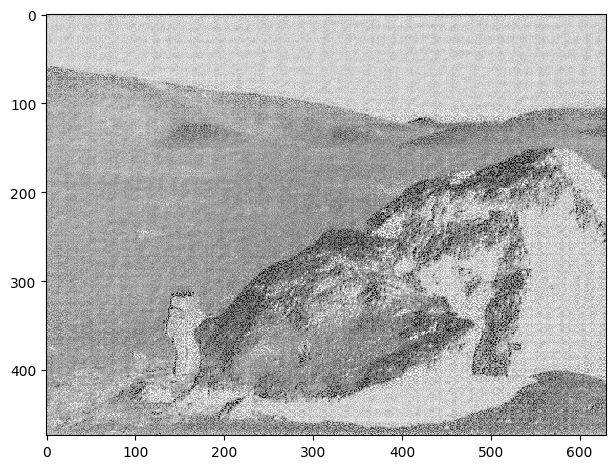

In [142]:
image_denoised = denoise(gray_image, 98)
# Użyty obraz ma szumy o wyskoiej częstotliwości co pozwala na łatwe ich usunięcie bez utraty detali jednak szumy nie zawsze są wysokiej częstotliwości co utrudnia ich usunięcie bez utraty detali
io.imshow(image_denoised, cmap='Greys')

(<matplotlib.image.AxesImage at 0x16722fae960>, dtype('uint8'))

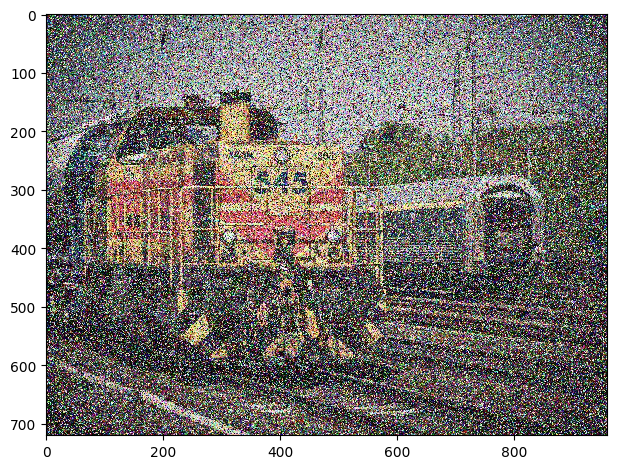

In [143]:
io.imshow(image_rgb), image_rgb.dtype

In [144]:

def denoise_rgb(channel, percentile):
    # Przeprowadzenie transformacji Fouriera i przesunięcie częstotliwości
    f_transform = np.fft.fftshift(np.fft.fft2(channel))
    
    # Obliczenie progu amplitudy na podstawie procentylu
    amplitude_threshold = np.percentile(np.abs(f_transform), percentile)
    
    # Usunięcie częstotliwości o niskiej amplitudzie
    f_transform[np.abs(f_transform) < amplitude_threshold] = 0
    
    # Odwrotna transformacja Fouriera i przesunięcie spowrotem
    channel_denoised = np.abs(np.fft.ifft2(np.fft.ifftshift(f_transform)))
    
    return channel_denoised
    

In [145]:
# Podzielenie obrazu na kanały
red_channel = image_rgb[:,:,0]
green_channel = image_rgb[:,:,1]
blue_channel = image_rgb[:,:,2]

percentile = 99

denoised_red = denoise_rgb(red_channel, percentile)
denoised_green = denoise_rgb(green_channel, percentile)
denoised_blue = denoise_rgb(blue_channel, percentile)

denoised_image = np.stack([denoised_red, denoised_green, denoised_blue], axis=-1)

# Normalizacaja
denoised_image = denoised_image / np.max(denoised_image)


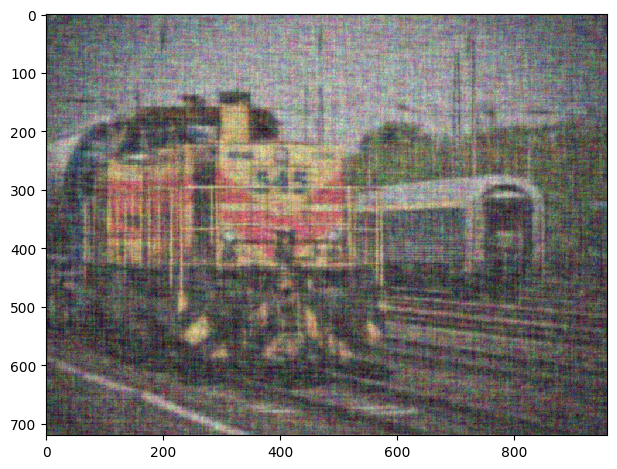

In [146]:
# Został zastosowany filtr który usówa niskie częstotliwości przez co obraz jest rozmazany
io.imshow(denoised_image)

# **Kompresja**

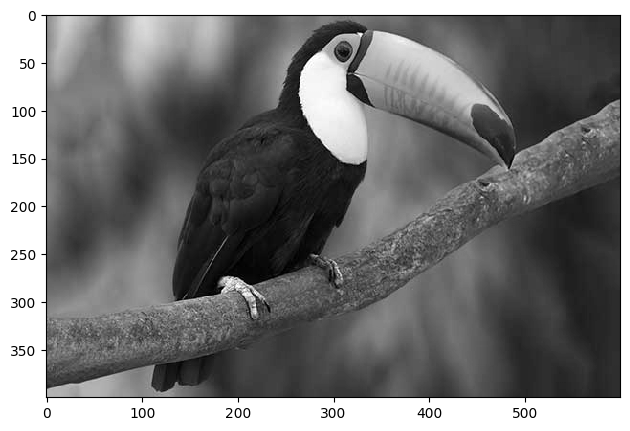

In [147]:
image_gray2 = io.imread("/Users/piotr/Downloads/tukan-wielki.jpg", as_gray=True)
image_rgb2 = io.imread("/Users/piotr/Downloads/tukan-wielki.jpg")
io.imshow(image_gray2)

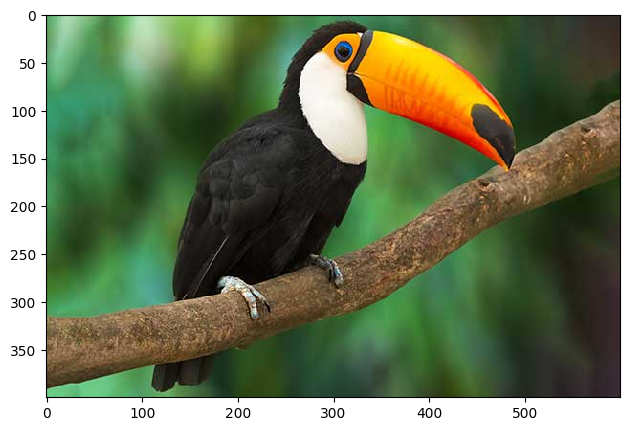

In [148]:
io.imshow(image_rgb2)

In [149]:
def compress_image(image, compression_ratio):
    # Transformacja fouriera i przesunięcie częstotliwości
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    
    # Obliczenie amplitudy i fazy
    amplitude = np.abs(f_shifted)
    phase = np.angle(f_shifted)
    
    compression_ratio = (1 - compression_ratio) * 100
    
    #Kompresja zachowanie najwyższych częstotliwości
    compressed_amplitude = amplitude * (amplitude > np.percentile(amplitude, compression_ratio))
    
    compressed_fourier_img = compressed_amplitude * np.exp(1j * phase)
    
    #Odwrócenie przsunięcia
    compressed_reshifted = np.fft.ifftshift(compressed_fourier_img)
    
    #Odwrócenie foureiera dekompresja
    decompressed_image = np.fft.ifft2(compressed_reshifted)
    
    decompressed_image = np.abs(decompressed_image)
    decompressed_image /= np.max(decompressed_image)
    
    return decompressed_image

In [150]:
compression_ratio = 0.2

In [151]:
compressed_img = compress_image(image_gray2, compression_ratio)

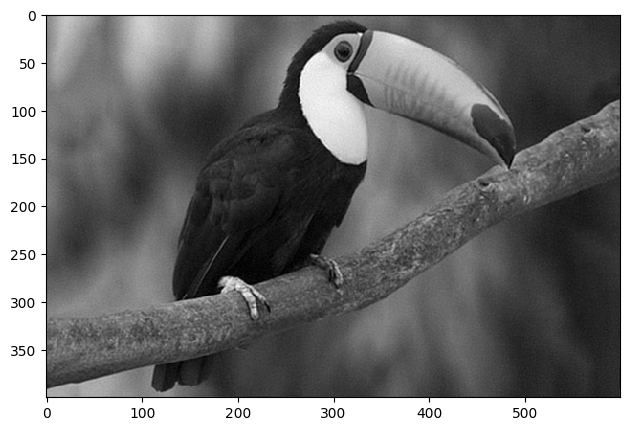

In [152]:
# Zmiany widac dopiero po usunięcu około 80% częstotliwości, na tukanie dopiero po usunięciu 95%
io.imshow(compressed_img)

In [153]:
name = "tukan"
summary = []

for compression in (1, 0.9, 0.7, 0.5, 0.3, 0.15, 0.1, 0.05, 0.01, 0.001):
    compressed_img = compress_image(image_gray2, compression)
    error =  mean_absolute_error(image_gray2, compressed_img)
    summary.append({"image": name, "compression": compression, "error": error})

In [154]:
pd.DataFrame.from_dict(summary).head(10)

image  compression     error
0  tukan        1.000  0.000400
1  tukan        0.900  0.000908
2  tukan        0.700  0.007394
3  tukan        0.500  0.016395
4  tukan        0.300  0.018839
5  tukan        0.150  0.017163
6  tukan        0.100  0.020634
7  tukan        0.050  0.021902
8  tukan        0.010  0.028815
9  tukan        0.001  0.055267

In [155]:
def compress_rgb(image, compression_ratio):
    # Wykonanie transformaty dla każdego kanału
    f_transform_rgb = np.fft.fftn(image, axes=(0, 1))
    
    # Przesunięcie częstotliwosci
    f_shifted_rgb = np.fft.fftshift(f_transform_rgb, axes=(0, 1))
    
    # Obliczenie amplitudy i fazy
    amplitude = np.abs(f_shifted_rgb)
    phase = np.angle(f_shifted_rgb)
    
    compression_ratio = (1 - compression_ratio) * 100
    
    # Kompresja
    compressed_amplitude = amplitude * (amplitude > np.percentile(amplitude, compression_ratio))
    
    compressed_fourier_img_rgb = compressed_amplitude * np.exp(1j * phase)
    
    # Przesunięcie spowrotem
    compressed_reshifted = np.fft.ifftshift(compressed_fourier_img_rgb, axes=(0, 1))
    
    # Odwrotna transformata Fouriera dla każdego kanału dekompresja
    decompressed_img_rgb = np.fft.ifftn(compressed_reshifted, axes=(0, 1))
    
    decompressed_img_rgb = np.abs(decompressed_img_rgb)
    decompressed_img_rgb /= np.max(decompressed_img_rgb)
    
    return decompressed_img_rgb

In [168]:
compression_ratio = 0.05

In [169]:
compressed_img_rgb = compress_rgb(image_rgb2, compression_ratio)

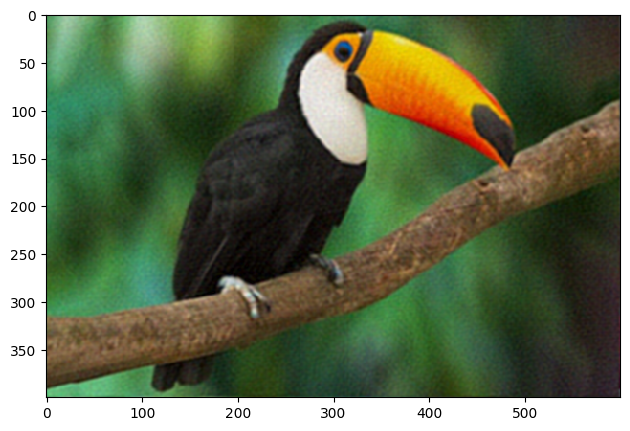

In [170]:
# Zmiany widac dopiero po usunięcu około 80% częstotliwości w tle, na tukanie dopiero po usunięciu 95%
io.imshow(compressed_img_rgb)